In [18]:
import triton
print(triton.__version__)

3.5.0


In [1]:

import math

def too_naive_softmax(x):
    max_mem = max(x)
    result = [math.e**(xi-max_mem) for xi in x]
    sum_all = sum(result)
    for i in range(len(x)):
        result[i] = result[i]/sum_all
    return result

In [2]:
x = [1000, 999, 998]
too_naive_softmax(x)

[0.6652409557748218, 0.24472847105479764, 0.09003057317038046]

In [3]:
import torch
def naive_softmax(x):
    M, N = x.shape
    # read MN elements, write M elements
    max_mem = torch.max(x, dim=-1).values
    # read MN + M elements, write MN elements
    z = x - max_mem.unsqueeze(-1).expand(M, N)
    # read MN elements, write MN elements
    z = torch.exp(z)
    # read MN elements, write M elements
    row_sum = torch.sum(z,-1).unsqueeze(-1).expand(M, N)
    # read MN + M elements, write MN elements
    result = z/row_sum
    # Total:: Read: 5MN + 2M; Write: 3MN+2M
    return result
    

In [4]:

x = torch.tensor([[2.0,1.0,0.1],[1000, 999, 998]])
naive_softmax(x)

tensor([[0.6590, 0.2424, 0.0986],
        [0.6652, 0.2447, 0.0900]])

In [5]:
import triton
import triton.language as tl
from triton.runtime import driver

DEVICE = triton.runtime.driver.active.get_active_torch_device()

def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')


@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr):
    # tl.device_print("BLOCK_SIZE", BLOCK_SIZE)
    pid = tl.program_id(0)
    row_start_ptr = input_ptr + pid * input_row_stride
    col_offsets = tl.arange(0, BLOCK_SIZE)
    input_ptrs = row_start_ptr + col_offsets
    # Load the row data into a block. Use a mask for rows shorter than BLOCK_SIZE.
    mask = col_offsets < n_cols
    row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
    row_max = tl.max(row, axis=0)
    numerator = tl.exp(row - row_max)
    denominator = tl.sum(numerator, axis=0)
    output = numerator / denominator
    
    # Store the result back to global memory.
    output_ptrs = output_ptr + pid * output_row_stride + col_offsets
    tl.store(output_ptrs, output, mask=mask)

In [6]:
def triton_softmax(x: torch.Tensor):
    if not x.is_cuda:
        x = x.cuda()

    n_rows, n_cols = x.shape
    output = torch.empty_like(x)
    grid = (n_rows,)

    softmax_kernel[grid](
        output_ptr=output, 
        input_ptr=x, 
        input_row_stride=x.stride(0),
        output_row_stride=output.stride(0),
        n_rows=n_rows,
        n_cols=n_cols,
        BLOCK_SIZE=triton.next_power_of_2(n_cols)
    )
    
    return output

In [7]:
x = torch.tensor([[2.0,1.0,0.1],[1000, 999, 998]], device=DEVICE)
triton_softmax(x)

tensor([[0.6590, 0.2424, 0.0986],
        [0.6652, 0.2447, 0.0900]], device='cuda:0')

In [63]:
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE': 512,  'VEC': 2, 'num_warps': 4, 'num_stages': 1}),
        triton.Config({'BLOCK_SIZE': 1024, 'VEC': 2, 'num_warps': 4, 'num_stages': 2}),
        triton.Config({'BLOCK_SIZE': 1024, 'VEC': 4, 'num_warps': 4, 'num_stages': 1}),
        triton.Config({'BLOCK_SIZE': 2048, 'VEC': 4, 'num_warps': 8, 'num_stages': 2}),
        triton.Config({'BLOCK_SIZE': 512,  'VEC': 4, 'num_warps': 8, 'num_stages': 1}),
        # wide rows
        triton.Config({'BLOCK_SIZE': 4096,  'VEC': 4, 'num_warps': 8,  'num_stages': 2}),
        triton.Config({'BLOCK_SIZE': 8192,  'VEC': 4, 'num_warps': 8,  'num_stages': 2}),
        triton.Config({'BLOCK_SIZE': 8192,  'VEC': 4, 'num_warps': 16, 'num_stages': 2}),
        triton.Config({'BLOCK_SIZE': 16384, 'VEC': 4, 'num_warps': 8,  'num_stages': 3}),
        triton.Config({'BLOCK_SIZE': 4096,  'VEC': 4, 'num_warps': 16, 'num_stages': 3}),
    ],
    key=['n_cols']
)
@triton.jit
def softmax_rowwise(
    out_ptr, in_ptr,
    in_row_stride, out_row_stride,
    n_cols: tl.int32,
    BLOCK_SIZE: tl.constexpr,  # elements per program, across the whole row, processed in tiles
    VEC: tl.constexpr          # per-thread vector width, use 4 when alignment allows
):
    pid = tl.program_id(0)
    row_in  = in_ptr  + pid * in_row_stride
    row_out = out_ptr + pid * out_row_stride

    # Online pass 1: compute row max and normalizer without storing intermediates
    m = tl.full((), -float('inf'), tl.float32)   # running max
    s = tl.zeros((), tl.float32)                 # running sum of exp(x - m)

    # Tile over columns in steps of BLOCK_SIZE*VEC
    tile_span = BLOCK_SIZE * VEC
    n_tiles = (n_cols + tile_span - 1) // tile_span  # runtime integer division
    for tile_start in range(0, n_tiles):
        cols = tile_start * tile_span + tl.arange(0, BLOCK_SIZE * VEC)
        mask = cols < n_cols
        ptrs = row_in + cols

        # Help the compiler vectorize. If your rows are contiguous and 16-byte aligned this will trigger float4-style ld/st.
        tl.multiple_of(cols, VEC)          # per-thread lane is contiguous
        # tl.assume_aligned(ptrs, 16)        # encourage 128-bit memory ops

        x = tl.load(ptrs, mask=mask, other=-float('inf'))

        # local max for this tile
        tile_max = tl.max(x, axis=0)
        m_new = tl.maximum(m, tile_max)

        # rescale the running sum to the new max, then add this tile’s contribution
        s = s * tl.exp(m - m_new) + tl.sum(tl.exp(x - m_new), axis=0)
        m = m_new

    # Pass 2: write normalized output
    inv_s = 1.0 / s
    for tile_start in range(0, n_tiles):
        cols = tile_start * tile_span + tl.arange(0, BLOCK_SIZE * VEC)
        mask = cols < n_cols
        ptrs = row_in + cols

        tl.multiple_of(cols, VEC)
        # tl.assume_aligned(ptrs, 16)

        x = tl.load(ptrs, mask=mask, other=-float('inf'))
        y = tl.exp(x - m) * inv_s
        tl.store(row_out + cols, y, mask=mask)


def triton_softmax2(x):
    import torch
    if not x.is_cuda:
        x = x.cuda(non_blocking=True)
    n_rows, n_cols = x.shape
    out = torch.empty_like(x)
    grid = (n_rows,)
    softmax_rowwise[grid](
        out_ptr=out,
        in_ptr=x,
        in_row_stride=x.stride(0),
        out_row_stride=out.stride(0),
        n_cols=n_cols,
    )
    return out

In [64]:
x = torch.tensor([[2.0,1.0,0.1],[1000, 999, 998]], device=DEVICE)
triton_softmax2(x)

tensor([[0.6590, 0.2424, 0.0986],
        [0.6652, 0.2447, 0.0900]], device='cuda:0')

In [56]:
import os
import torch
from torch.utils.cpp_extension import load

# this_dir = os.path.dirname(__file__)

this_dir = os.getcwd()
ext = load(
  name="softmax_ext",
  sources=[
    os.path.join(this_dir, "softmax.cpp"),
    os.path.join(this_dir, "softmax_kernel.cu"),
  ],
  verbose=True,
)

def cuda_softmax(x: torch.Tensor):
  return ext.softmax_cuda(x)

x = torch.tensor([[2.0,1.0,0.1],[1000, 999, 998]], device=DEVICE)
cuda_softmax(x)

[1/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output softmax_kernel.cuda.o.d -DTORCH_EXTENSION_NAME=softmax_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -isystem /venv/main/lib/python3.12/site-packages/torch/include -isystem /venv/main/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /venv/main/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_120,code=compute_120 -gencode=arch=compute_120,code=sm_120 --compiler-options '-fPIC' -std=c++17 -c /workspace/softmax_kernel.cu -o softmax_kernel.cuda.o 
[2/3] c++ -MMD -MF softmax.o.d -DTORCH_EXTENSION_NAME=softmax_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -isystem /venv/main/lib/python3.12/site-packages/torch/include -isystem /venv/main/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/

tensor([[0.6590, 0.2424, 0.0986],
        [0.6652, 0.2447, 0.0900]], device='cuda:0')

In [61]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        # X-axis configuration: the independent variable we're testing
        x_names=['N'],  # Parameter name that varies across benchmark runs
        x_vals=[128*i for i in range(10, 351, 20)],  # Test sizes from 2^8 (256) to 2^27 (134M) elements
        # x_log=True,  # Use logarithmic scale for x-axis (better for exponential ranges)

        # Line configuration: compare different implementations
        line_arg='provider',  # Parameter that distinguishes different implementations
        line_vals=['triton', 'torch', 'triton_softmax2', 'cuda_softmax'],  # Internal identifiers for each implementation
        # line_vals=['triton', 'torch', 'triton_softmax2', 'cuda_softmax'],  # Internal identifiers for each implementation
        line_names=['triton','Torch', 'triton_softmax2', 'cuda_softmax'],  # Display names for the legend
        # line_names=['Triton', 'Torch', 'triton_softmax2', 'cuda_softmax'],  # Display names for the legend
        styles=[('blue', '-'), ('green', '-'), ('red', '-'),  ('black', '-.')],  # (color, line_style) tuples

        # Plot configuration
        ylabel='GB/s',  # Y-axis label (measuring memory bandwidth)
        plot_name='softmax-performance',  # Output filename and plot title
        args={'M': 256},  # Additional fixed arguments (empty here since we only vary size/provider)
    ))
    # basically, the above decorator says that I'm going to have a 2D Diagram
    # x values would be 'size' and lines would be triton, torch and cuda.
def benchmark(M, N, provider):
    """
    Benchmarks vector addition across three implementations: PyTorch, Triton, and CUDA.

    Args:
        size: Number of elements in the vectors
        provider: Which implementation to benchmark ('torch', 'triton', or 'cuda')

    Returns:
        Tuple of (median_gbps, min_gbps, max_gbps) representing bandwidth at different quantiles
    """
    # Create random input tensors on the specified device
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)

    for _ in range(5):
        if provider == 'torch':
            torch.softmax(x, axis=-1)
        elif provider == 'triton':
            triton_softmax(x)
        else:
            naive_softmax(x)
    torch.cuda.synchronize()
    # Quantiles for statistical analysis: [median, 20th percentile, 80th percentile]
    # This captures the distribution of timings across multiple runs
    quantiles = [0.5, 0.2, 0.8]

    # Benchmark each implementation
    # do_bench runs the lambda multiple times and returns timing statistics
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        # Native PyTorch element-wise addition
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1), quantiles=quantiles)
    if provider == 'triton':
        # Custom Triton kernel implementation
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_softmax(x), quantiles=quantiles)
    if provider == 'triton_softmax2':
        # Custom CUDA kernel implementation
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_softmax2(x), quantiles=quantiles)
    if provider == 'cuda_softmax':
        # Custom CUDA kernel implementation
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: cuda_softmax(x), quantiles=quantiles)

    # Calculate memory bandwidth in GB/s
    # Formula breakdown:
    #   - 3 * x.numel(): total elements accessed (read x, read y, write output)
    #   - x.element_size(): bytes per element (4 bytes for float32)
    #   - 1e-9: convert bytes to gigabytes
    #   - (ms * 1e-3): convert milliseconds to seconds
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)

    # Return bandwidth for median, fastest (max_ms → min bandwidth), and slowest (min_ms → max bandwidth)
    # Note: max_ms gives min bandwidth and vice versa
    return gbps(ms), gbps(max_ms), gbps(min_ms)

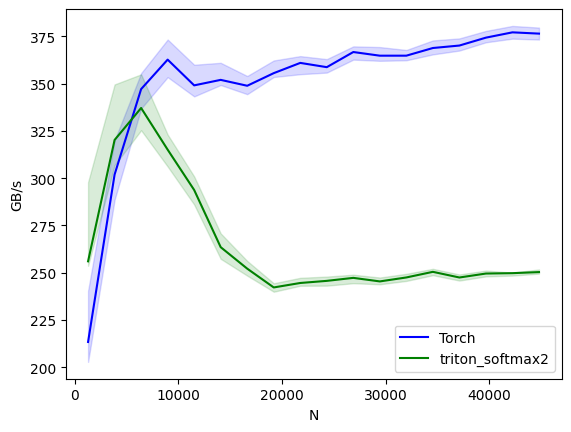

softmax-performance:
          N       Torch  triton_softmax2
0    1280.0  213.333326       256.000006
1    3840.0  301.916451       320.208459
2    6400.0  347.118638       337.119326
3    8960.0  362.707136       315.076922
4   11520.0  349.090906       293.737049
5   14080.0  352.000009       263.485383
6   16640.0  348.881249       252.121210
7   19200.0  355.555555       242.175799
8   21760.0  360.974594       244.537321
9   24320.0  358.718581       245.656573
10  26880.0  366.727769       247.243464
11  29440.0  364.793806       245.365281
12  32000.0  364.802286       247.462552
13  34560.0  368.855171       250.434777
14  37120.0  370.158929       247.440898
15  39680.0  374.339624       249.535216
16  42240.0  377.142852       249.733031
17  44800.0  376.470599       250.301170


In [37]:
benchmark.run(show_plots=True, print_data=True)

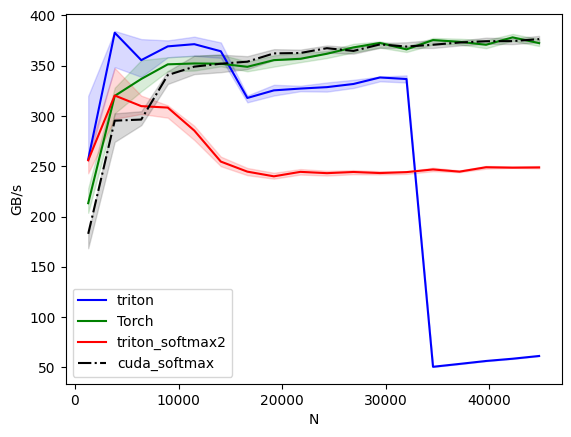

softmax-performance:
          N      triton       Torch  triton_softmax2  cuda_softmax
0    1280.0  256.802497  213.333326       256.000006    182.857140
1    3840.0  382.803739  319.999989       320.417202    295.384619
2    6400.0  355.555543  336.842120       309.833586    296.489314
3    8960.0  369.246631  351.372555       308.383981    340.724894
4   11520.0  371.425696  352.259896       285.546077    349.090906
5   14080.0  364.383344  352.000009       254.697574    352.000009
6   16640.0  317.945972  348.938406       244.705878    354.042543
7   19200.0  325.509925  355.555555       240.046880    362.264153
8   21760.0  327.294944  356.904160       244.494379    362.666676
9   24320.0  328.718059  361.887940       243.200006    367.440971
10  26880.0  331.851859  368.219164       244.363634    364.706394
11  29440.0  338.330054  372.658239       243.305791    371.189913
12  32000.0  336.786714  366.237484       244.245682    369.075502
13  34560.0   50.711665  375.524609      

In [62]:
benchmark.run(show_plots=True, print_data=True)

In [ ]:
benchmark.run(show_plots=True, print_data=True)